# 模型结构

线性回归 （Linear Regression） 是一种简单的回归模型，其模型可表示为：
$$
f_w(X) = XW
$$

其中 $x_i, w \in \mathbb{R}^P$, $w$ 是需要学习的参数

In [1]:
import numpy as np

生成 data：
$$
Y = Xw
$$

In [2]:
X=np.linspace(0,100,100)    # 将 0~100 划分100份

X = X.reshape(100,1)
w = np.asarray([4])         # w 的真值
Y = X.dot(w)                # Y = XW, Y.shape = (100, )

X=X.astype('float')
Y=Y.astype('float')

添加噪声， $Y = \widehat{Y} + 10 \times \epsilon$

给 高斯噪声 $\epsilon \times 10$ 是为了能更清楚的看到偏移量（噪声）

In [3]:
Y_T = Y + 10 * np.random.normal(size=(Y.shape))#添加噪声

Y_T=Y_T.reshape(100,1)   # 规范化维度

绘制 data

Text(0, 0.5, 'Y')

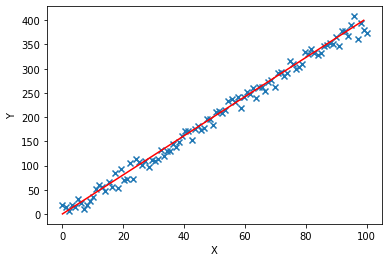

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:,0],Y_T, marker='x')            # 绘制点集
plt.plot(np.arange(0,100).reshape((100,1)),Y,'r')   # 绘制 曲线
plt.xlabel('X')
plt.ylabel('Y')

# 损失函数

上边生成了 $Y = 3X + 10 \times \epsilon$ 的数据，线性回归的**目的**就是在只有 $X, Y$ 的情况下，来推算出最优的 $f_w(X)= Xw$。

我们使用 `最小二乘法` 来估计 $w$，使用 `MSE`（均方误差，二范数）来衡量$f_w(X)$ 与 $Y$ 的相似度：

$$
L(w) = \sum_{i=1}^N (f_w(x_i) - y_i)^2 = \sum_{i=1}^N (x_i w - y_i)^2 = (Xw-Y)^T(Xw-Y)
$$

这里 $N$ 表示样本容量，本例中 $N=100$，$x_i, y_i$ 表示第 $i$ 个样本，$x_i \in \mathbb{R}^P, y_i \in \mathbb{R}^1$，所以 $X \in \mathbb{R}^{N \times P}, Y \in \mathbb{R}^{N \times 1}, i=1,2,\cdots,N$，损失函数 $L(w)$ 本质上是关于 $w$ 的函数，通过求最小的 $L(w)$ 即可得到 $w$ 的最优解。

$$
\widehat{w} = \mathop{argmin}\limits _{w}L(w)
$$

## 方法一：直接求闭式解
$\mathop{argmin}\limits _{w}L(w)$ 是一个明显的凸优化问题，其中海瑟矩阵 $X^TX$ 是正定的，因此我们可以直接通过求解 $\frac{\partial {L(w)}}{\partial w} = 0$ 来获得 $\widehat{w}$：

$$
\frac{\partial {L(w)}}{\partial w} = 2X^TXw-2X^TY
$$

令：$\frac{\partial {L(w)}}{\partial w}=0$，可得 $\widehat{w}=(X^TX)^{-1}X^TY = X^+ Y$，其中 $X^+$ 成为 $X$ 的伪逆。

> 当 $X^TX$ `满秩` 时，可直接求解$(X^TX)^{-1}$，然而实际情境中，可能会有 $N<P$ （数据量小于参数量）的情况出现，使得 $w$ 的解有无数种，导致无法对 $(X^TX)$求逆。
>
> 当出现这种情况时，有三种解决办法：
> - 加数据量（比较直观的方法，不用解释）
> - 正则化（后面会讲，就是给$X^TX + \lambda I$ 这样就满秩了，一定可导）
> - 特征提取/特征选择 （降维）

实际求解过程中，更多的是对 $X$ 进行奇异值分解（SVD），就有
$$
X=U\Sigma V^T
$$
因此：
$$
X^+=V\Sigma^{-1}U^T
$$
其中，$U,\Sigma,V$是矩阵$X^*$做奇异值分解（SVD）后得到的矩阵，对角矩阵$\Sigma$的伪逆$\Sigma^+$由其非零元素取倒数之后再转置得到，通过伪逆求解到的结果有如下优点：

（1）当$w$ `有解` 时，$\widehat{w}={X}^+Y$ 是所有解中，欧几里得距离 $||w||_2$ 最小的一个（$||\widehat{w}-w||_2$）；

（2）当$w$ `无解` 时，通过伪逆得到的 $\widehat{w}$ 是使得 $X^*w^*$ 与 $Y$ 的欧几里得距离 $||X^*w^*-Y||_2$ 最小

`np.linalg.pinv(x)` # 求X的广义逆矩阵

In [5]:
w=np.linalg.pinv(X).dot(Y)  # X^+ * Y
w

array([4.])

Text(0, 0.5, 'Y')

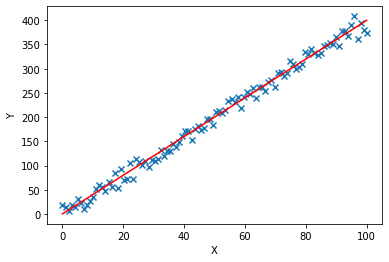

In [6]:
#可视化
plt.scatter(X[:,0],Y_T, marker='x')
plt.plot(X[:,0],X.dot(w),'r')
plt.xlabel('X')
plt.ylabel('Y')

## 方法二：梯度下降法求解

但对于数据量很大的情况，求闭式解的方式会让内存很吃力，我们可以通过`随机梯度下降法（SGD）`对 $w$ 进行迭代更新求最优解，首先随机初始化 $w$，然后使用如下的迭代公式对 $w$ 进行迭代更新：
$$
w:=w-\eta\frac{dL}{dw} = w - (2X^TXw-2X^TY) = w - 2X^T(Xw-Y)
$$

In [9]:
w=np.random.random(size=(1,1))  # 随机一个初始状态

# 参数初始化
epoches=100
lr=1e-6
losses=[]#记录loss变化
for _ in range(epoches):
    dw=-2*X.T.dot(Y_T-X.dot(w))   # L对w求导
    w=w-lr*dw
    losses.append((Y_T-X.dot(w)).T.dot(Y_T-X.dot(w)).reshape(-1)) # 二范数
w

array([[3.9890768]])

Text(0, 0.5, 'Y')

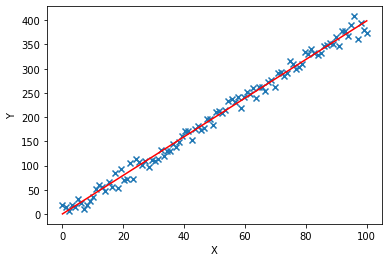

In [10]:
#可视化
plt.scatter(X[:,0],Y_T, marker='x')
plt.plot(X[:,0],X.dot(w),'r')
plt.xlabel('X')
plt.ylabel('Y')

Text(0, 0.5, 'loss')

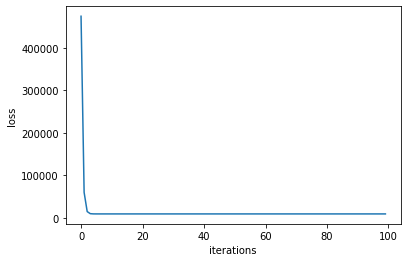

In [9]:
#loss变化
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')